# HandSegNet Demo

This notebook shows how HandSegNet is used.

In [15]:
import os
import sys
import math

import torch
import torchvision
import torch.nn.functional as F
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

model_path = os.path.abspath(os.path.join('..'))
if model_path not in sys.path:
    sys.path.append(model_path)
    
from colorhandpose3d.model.HandSegNet import HandSegNet
from colorhandpose3d.utils.general import *
import dilation2d

## Initialization

Create the model and initialize the weights.

In [16]:
handsegnet = HandSegNet()

## Import weights from Tensorflow model

The original HandSegNet was implemented in Tensorflow. The pre-trained model weights need to be imported.

In [17]:
file_name = '/home/ajdillhoff/Downloads/ColorHandPose3D_data_v3/weights/handsegnet-rhd.pickle'
session = tf.Session()
exclude_var_list = list()
# exclude_var_list = ['HandSegNet/conv5_2/weights', 
#                     'HandSegNet/conv5_2/biases', 
#                     'HandSegNet/conv6_1/weights', 
#                     'HandSegNet/conv6_1/biases']

# read from pickle file
with open(file_name, 'rb') as fi:
    weight_dict = pickle.load(fi)
    weight_dict = {k: v for k, v in weight_dict.items() if not any([x in k for x in exclude_var_list])}
    
for name, module in handsegnet.named_children():
    key = 'HandSegNet/{0}/'.format(name)
    if key + 'biases' in weight_dict:
        b = torch.Tensor(weight_dict[key + 'biases'])
        w = torch.Tensor(weight_dict[key + 'weights'])
        w = w.permute((3, 2, 1, 0))
        module.weight.data = w
        module.bias.data = b
        
torch.save(handsegnet.state_dict(), '/home/ajdillhoff/dev/projects/colorhandpose3d-pytorch/saved/handsegnet.pth.tar')

## Test HandSegNet on a sample

Now that the pre-trained weights are loaded, test a sample from RHD.

In [18]:
def visualize_mask(img, mask):
    plt.figure(figsize=(16, 16))
    plt.subplot(121)
    plt.imshow(img)
    
    plt.subplot(122)
    plt.imshow(mask)
    plt.show()

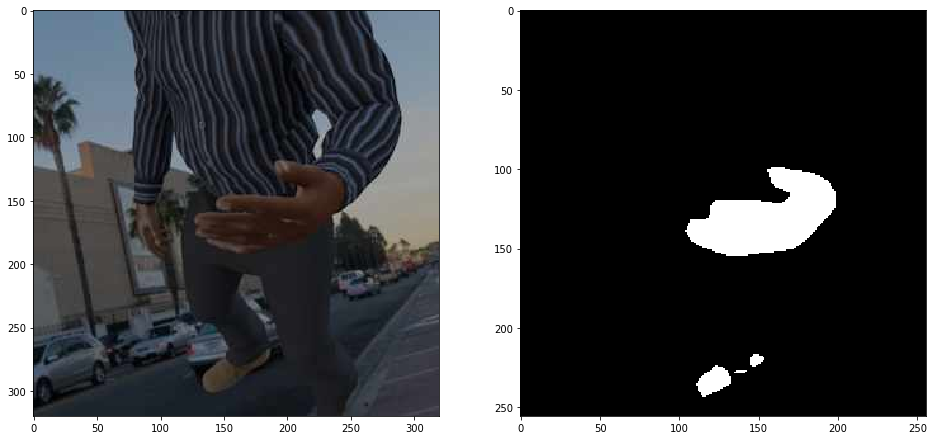

In [19]:
transform0 = torchvision.transforms.ToPILImage()
transform1 = torchvision.transforms.ToTensor()
transform2 = torchvision.transforms.Resize(256)
img = Image.open('/home/ajdillhoff/Downloads/RHD_v1-1/RHD_published_v2/training/color/00001.png')
sample_original = transform1(transform2(img)).unsqueeze(0)
sample = sample_original - sample_original.mean()
output = handsegnet.forward(sample)
mask = output.argmax(1).to(torch.float)
mask_img = transform0(mask.to(torch.float))

visualize_mask(img, mask_img)

## Morphological Dilation

Before we can implement the utility function `single_obj_scoremap` from the Tensorflow implementation, morphological dilation needs to be implemented in PyTorch. There are currently no implementations of this.

In [20]:
def dilation(x, kernel, stride=[1, 1], rates=[1, 1], padding=[0, 0]):
    """Computes the dilation of a 4D input with a 3D kernel.
    
    Args:
        x - (batch_size, channel_size, height, width): Input `Tensor`.
        kernel - (chanel_size, height, width): Dilation kernel.
        stride - (stride_height, stride_width): A list of `int`s determining
            the stride of the `kernel`.
        rates - (rate_height, rate_width): A list of `int`s determining the stride
            for atrous morphological dilation.
        padding - (padding_height, padding_width): A list of `int`s defining the amount
            of padding to add to the input `Tensor`.
            
    Returns:
        A `Tensor` with the same type as `x`.
    """
    # TODO(Alex): Check that the dilation rate and kernel size are appropriate given the input size.
    assert len(x.shape) == 4, "Input must be 4D (N, C, H, W)"
    assert len(kernel.shape) == 3, "Kernel must be 3D (C, H, W)"
    
    # Calculate output height and width
    output_height = math.floor((x.shape[2] + 2 * padding[0] - kernel.shape[1]) / stride[0]) + 1
    output_width = math.floor((x.shape[3] + 2 * padding[1] - kernel.shape[2]) / stride[1]) + 1
    
    output = torch.zeros(x.shape[0], x.shape[1], output_height, output_width)
    
    # C++ implementation
    dilation2d.dilation2d(x, kernel, stride[0], stride[1], rates[0], rates[1], padding[0], padding[1], output)
    
    return output

## Single Object Scoremap

The result of HandSegNet goes through some intermediate processing steps. The first is to find the most likely object in the segmentation map.

In [21]:
def max_coordinate_dense(x):
    """Calculates the x, y coordinates of the maximum value (per channel) in a matrix.
    
    Args:
        x - (batch_size, channel_size, height, width): Input tensor.
    
    Returns:
        A tensor of size (batch_size, channel_size, height, width) where each batch item
        is a zero-matrix per channel except for the location of the largest calculated value.
    """
    
    s = x.shape
        
    if len(s) == 3:
        output = torch.zeros_like(x, dtype=torch.int32)
        coords = x.view(s[0], -1)
        _, max_coords = torch.max(coords, -1)
        X = torch.remainder(max_coords[:], s[1])
        Y = max_coords[:] / s[2]
        output[:, Y, X] = 1
        
    return output

def single_obj_scoremap(mask, filter_size=21):
    """Calculates the most likely object given the segmentation score map."""
    
    padding_size = math.floor(filter_size / 2)
    s = mask.shape
    assert len(s) == 4, "Scoremap must be 4D."
    
    scoremap_softmax = F.softmax(mask, dim=1)
    scoremap_softmax = scoremap_softmax[:, 1, :, :].unsqueeze(0)
    scoremap_fg_vals, scoremap_fg_idxs = scoremap_softmax.max(dim=1, keepdim=False)
    detmap_fg = torch.round(scoremap_fg_vals)
    
    max_loc = max_coordinate_dense(scoremap_fg_vals).to(torch.float32)
    
    objectmap_list = []
    kernel_dil = torch.ones(1, filter_size, filter_size) / float(filter_size * filter_size)
        
    for i in range(s[0]):
        # create initial object map
        objectmap = max_loc[i]
        
        num_passes = max(s[2], s[3]) // (filter_size // 2)
        for j in range(num_passes):
            objectmap = torch.reshape(objectmap, [1, 1, s[2], s[3]])
            objectmap_dil = dilation(objectmap, kernel_dil, padding=[padding_size, padding_size])
            objectmap_dil = torch.reshape(objectmap_dil, [s[2], s[3]])
            objectmap = torch.round(detmap_fg[i, :, :] * objectmap_dil)
            
        objectmap = torch.reshape(objectmap, [1, s[2], s[3]])
        objectmap_list.append(objectmap)
            
    return torch.stack(objectmap_list)

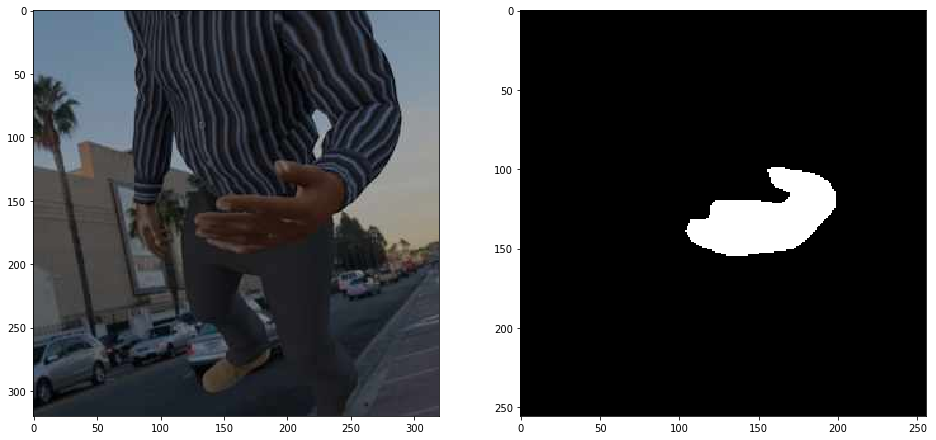

In [22]:
test_output = single_obj_scoremap(output, 21)
t_img = transform0(test_output[0])
visualize_mask(img, t_img)

## Calculate Bounding Box

The final step of the hand segmentation module is to calculate the bounding box and crop the hand from the original image.

In [23]:
def calc_center_bb(binary_class_mask):
    """Calculate the bounding box of the object in the binary class mask.
    
    Args:
        binary_class_mask - (batch_size x H x W): Binary mask isolating the hand.
        
    Returns:
        centers - (batch_size x 2): Center of mass calculation of the hand.
        bbs - (batch_size x 4): Bounding box of containing the hand. [x_min, y_min, x_max, y_max]
        crops - (batch_size x 2): Size of crop defined by the bounding box.
    """
    
    binary_class_mask = binary_class_mask.to(torch.int32)
    binary_class_mask = torch.eq(binary_class_mask, 1)
    if len(binary_class_mask.shape) == 4:
        binary_class_mask = binary_class_mask.squeeze(1)
        
    s = binary_class_mask.shape
    assert len(s) == 3, "binary_class_mask must be 3D."
    
    bbs = []
    centers = []
    crops = []
    
    for i in range(s[0]):
        y_min = binary_class_mask[i].nonzero()[:, 0].min()
        x_min = binary_class_mask[i].nonzero()[:, 1].min()
        y_max = binary_class_mask[i].nonzero()[:, 0].max()
        x_max = binary_class_mask[i].nonzero()[:, 1].max()
        
        start = torch.stack([y_min, x_min])
        end = torch.stack([y_max, x_max])
        bb = torch.stack([start, end], 1)
        bbs.append(bb)
        
        center_x = (x_max + x_min) / 2
        center_y = (y_max + y_min) / 2
        center = torch.stack([center_y, center_x])
        centers.append(center)
        
        crop_size_x = x_max - x_min
        crop_size_y = y_max - y_min
        crop_size = max(crop_size_y, crop_size_x)
        crops.append(crop_size)
        
    bbs = torch.stack(bbs)
    centers = torch.stack(centers)
    crops = torch.stack(crops)
    
    return centers, bbs, crops


def crop_image_from_xy(image, crop_location, crop_size, scale=1.0):
    """Crops an image.
    
    Args:
        image - Tensor (batch_size, C, H, W): Images to be cropped.
        crop_location - Tensor (batch_size, 2): Height and width locations to crop.
        crop_size - int: Size of the crop.
        scale - float: Scale factor.
        
    Returns:
        image_crop - Tensor (batch_size, C, crop_size, crop_size): Cropped images
    """
    
    s = image.shape
    assert len(s) == 4, "Image needs to be of shape (B x C x H x W)"
    crop_location = crop_location.to(torch.float32)
    
    crop_size_scaled = float(crop_size) / scale
    y1 = crop_location[:, 0] - crop_size_scaled // 2
    y2 = y1 + crop_size_scaled
    x1 = crop_location[:, 1] - crop_size_scaled // 2
    x2 = x1 + crop_size_scaled
    y1 /= s[2]
    y2 /= s[2]
    x1 /= s[3]
    x2 /= s[3]
    boxes = torch.stack([y1, x1, y2, x2], -1).to(torch.float32)
    
    box_ind = torch.arange(0, s[0], dtype=torch.int32)
    image_crops = CropAndResizeFunction(crop_size, crop_size, 0)(image, boxes, box_ind)
    
    return image_crops

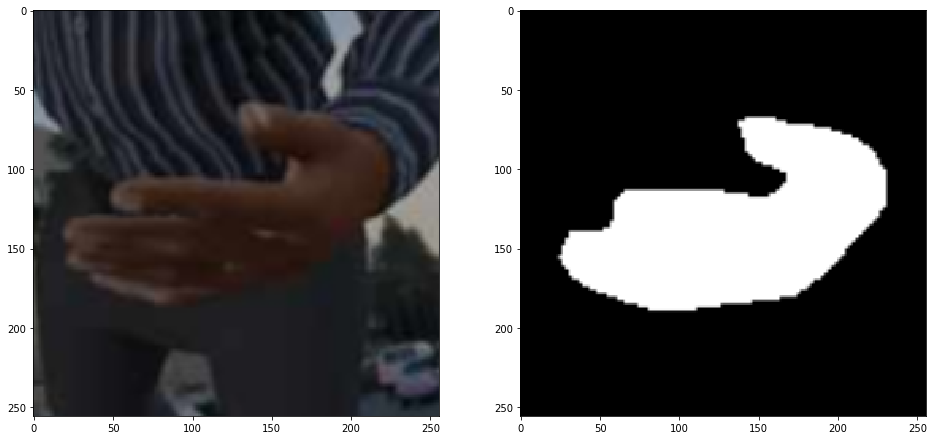

In [24]:
# Test the implementation of calc_center_bb
centers, bbs, crops = calc_center_bb(test_output)
crops = crops.to(torch.float32)
crop_size = 256

crops[0] *= 1.25
scale_crop = min(max(crop_size / crops[0], 0.25), 5.0)
image_crop = crop_image_from_xy(sample_original, centers, crop_size, scale_crop)
mask_crop = crop_image_from_xy(test_output, centers, crop_size, scale_crop)
img = transform0(image_crop[0])
mask_img = transform0(mask_crop[0])
visualize_mask(img, mask_img)